In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stats = pd.read_csv('cleaned_fbref_players.csv')

/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_1708/3895760055.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  stats = pd.read_csv('cleaned_fbref_players.csv')


In [3]:
num_cols = stats.select_dtypes(include='number').columns.drop('Min_Playing')

def agg_per_url(g):
    total_minutes = g['Min_Playing'].sum()
    # weighted averages
    out = {
        col: (g[col] * g['Min_Playing']).sum() / total_minutes
        for col in num_cols
    }
    out['Total_Min_Playing'] = total_minutes
    # carry along Player/Nation/Pos
    out['Player'] = g['Player'].iloc[0]
    out['Nation'] = g['Nation'].iloc[0]
    out['Pos']    = g['Pos'].iloc[0]
    return pd.Series(out)

# group and apply
weighted_by_url = stats.groupby('Url').apply(agg_per_url).reset_index()

/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_1708/230175768.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_by_url = stats.groupby('Url').apply(agg_per_url).reset_index()


In [4]:
front_cols = ['Url', 'Player', 'Nation', 'Pos']

other_cols = [c for c in weighted_by_url.columns if c not in front_cols]

weighted_by_url = weighted_by_url[ front_cols + other_cols ]

In [5]:
# Load your RAPM ratings CSV
ratings = pd.read_csv('baseline_model.csv')

ratings = ratings[['player_name','offense']]

ratings = ratings.rename(columns={
    'player_name': 'Player',
    'offense':     'offense_rating'
})

# Merge onto weighted_by_url
merged_df = weighted_by_url.merge(
    ratings,
    on='Player',
    how='left'           
)

In [6]:
# Feature & target 
FEATURE_COLS = [
    'PassLive_GCAPer90','GCA_GCAPer90','G+APer90',
    'npxG+xAG_ExpectedPer90','xAGPer90','xAG_ExpectedPer90',
    'Rec_ReceivingPer90','PassLive_SCAPer90',
    'G_minus_PKPer90','GlsPer90','Att Pen_TouchesPer90'
]
TARGET_COL = 'offense_rating'


FEATURE_COLS =  [
    "Won_percent_Aerial",
# "GlsPer90",
"AstPer90",
"G+APer90",
"G_minus_PKPer90",
"PKPer90",
"PKattPer90",
"CrdYPer90",
"CrdRPer90",
# "xG_ExpectedPer90",
"npxG_ExpectedPer90",
"xAG_ExpectedPer90",
"npxG+xAG_ExpectedPer90",
"PrgC_ProgressionPer90",
"PrgP_ProgressionPer90",
"PrgR_ProgressionPer90",
# "Mins_Per_90Per90",
"Touches_TouchesPer90",
"Def Pen_TouchesPer90",
"Def 3rd_TouchesPer90",
"Mid 3rd_TouchesPer90",
"Att 3rd_TouchesPer90",
"Att Pen_TouchesPer90",
"Live_TouchesPer90",
"Att_TakePer90",
"Succ_TakePer90",
"Succ_percent_TakePer90",
"Tkld_TakePer90",
# "Tkld_percent_TakePer90",
"Carries_CarriesPer90",
"TotDist_CarriesPer90",
"PrgDist_CarriesPer90",
"PrgC_CarriesPer90",
"Final_Third_CarriesPer90",
"CPA_CarriesPer90",
"Mis_CarriesPer90",
"Dis_CarriesPer90",
"Rec_ReceivingPer90",
"PrgR_ReceivingPer90",
"Tkl_TacklesPer90",
"TklW_TacklesPer90",
"Def 3rd_TacklesPer90",
"Mid 3rd_TacklesPer90",
"Att 3rd_TacklesPer90",
"Tkl_ChallengesPer90",
"Att_ChallengesPer90",
# "Tkl_percent_ChallengesPer90",
# "Lost_ChallengesPer90",
# "Blocks_BlocksPer90",
"Sh_BlocksPer90",
"Pass_BlocksPer90",
"IntPer90",
"Tkl+IntPer90",
"ClrPer90",
"ErrPer90",
"SCA_SCAPer90",
"SCA90_SCAPer90",
"PassLive_SCAPer90",
"PassDead_SCAPer90",
"TO_SCAPer90",
"Sh_SCAPer90",
"Fld_SCAPer90",
"Def_SCAPer90",
"GCA_GCAPer90",
"GCA90_GCAPer90",
"PassLive_GCAPer90",
"PassDead_GCAPer90",
"TO_GCAPer90",
"Sh_GCAPer90",
"Fld_GCAPer90",
"Def_GCAPer90",
"AttPer90",
"Live_PassPer90",
"Dead_PassPer90",
"FK_PassPer90",
"TB_PassPer90",
"Sw_PassPer90",
"Crs_PassPer90",
"TI_PassPer90",
"CK_PassPer90",
"In_CornerPer90",
"Out_CornerPer90",
"Str_CornerPer90",
"Cmp_OutcomesPer90",
"Off_OutcomesPer90",
"Blocks_OutcomesPer90",
"Cmp_TotalPer90",
"Att_TotalPer90",
"Cmp_percent_TotalPer90",
"TotDist_TotalPer90",
"PrgDist_TotalPer90",
"Cmp_ShortPer90",
"Att_ShortPer90",
"Cmp_percent_ShortPer90",
"Cmp_MediumPer90",
"Att_MediumPer90",
"Cmp_percent_MediumPer90",
"Cmp_LongPer90",
"Att_LongPer90",
"Cmp_percent_LongPer90",
"Ast_df7Per90",
"xAGPer90",
"xA_ExpectedPer90",
"A_minus_xAG_ExpectedPer90",
"KPPer90",
"Final_ThirdPer90",
"PPAPer90",
"CrsPAPer90",
"PrgPPer90",
"CrdY_df8Per90",
"CrdR_df8Per90",
"2CrdYPer90",
"FlsPer90",
"FldPer90",
"OffPer90",
"CrsPer90",
"Int_df8Per90",
"TklWPer90",
"PKwonPer90",
"PKconPer90",
"OGPer90",
"RecovPer90",
"Won_AerialPer90",
"Lost_AerialPer90",
# "Won_percent_AerialPer90",
# "90sPer90",
# "AvgTeamPoss",
# "OppTouches",
# "TeamMins",
# "TeamTouches90",
"pAdjTkl+IntPer90",
"pAdjClrPer90",
"pAdjShBlocksPer90",
"pAdjPassBlocksPer90",
"pAdjIntPer90",
"pAdjDrbTklPer90",
"pAdjTklWinPossPer90",
"pAdjDrbPastPer90",
"pAdjAerialWinsPer90",
"pAdjAerialLossPer90",
"pAdjDrbPastAttPer90",
"TouchCentrality",
"Tkl+IntPer600OppTouch",
"pAdjTouchesPer90",
"CarriesPer50Touches",
"ProgCarriesPer50Touches",
"ProgPassesPer50CmpPasses",
# "Total_Min_Playing",

]

df = merged_df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df[~df[TARGET_COL].isna()]
df_clean = df.dropna(subset=FEATURE_COLS)

# Split
X = df_clean[FEATURE_COLS]
y = df_clean[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) RidgeCV
alphas = np.logspace(-3, 3, 40)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2') 
ridge_cv.fit(X_train_scaled, y_train)

print(f"Best α by CV: {ridge_cv.alpha_:.4f}")

# 6) Evaluate
y_pred = ridge_cv.predict(X_test_scaled)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.3f}")

# 7) Coefficients
coef_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'coefficient': ridge_cv.coef_
}).assign(abs_coef=lambda d: d.coefficient.abs()
).sort_values('abs_coef', ascending=False
).drop(columns='abs_coef')

print("\nFeatures by |coef|:")
print(coef_df.to_string(index=False))

Best α by CV: 345.5107
Test MSE: 0.003
Test R²:  0.284

Features by |coef|:
                  feature  coefficient
       npxG_ExpectedPer90     0.008396
   npxG+xAG_ExpectedPer90     0.007519
        PassLive_GCAPer90     0.005900
          G_minus_PKPer90     0.005197
               RecovPer90     0.004757
         pAdjTouchesPer90    -0.004740
                  KPPer90    -0.004400
             GCA_GCAPer90     0.004320
                 G+APer90     0.004191
          Cmp_MediumPer90     0.004163
         xA_ExpectedPer90     0.004126
         Final_ThirdPer90     0.003931
               PKwonPer90     0.003875
     PrgDist_CarriesPer90     0.003531
     Att Pen_TouchesPer90     0.003503
           Cmp_TotalPer90     0.003337
        Cmp_OutcomesPer90     0.003337
       TotDist_TotalPer90     0.003303
       PrgDist_TotalPer90     0.003262
                 xAGPer90     0.003226
        xAG_ExpectedPer90     0.003226
                 FlsPer90     0.003022
                 FldPer90  

In [7]:
coef_df.sort_values(by='coefficient', ascending=False).head(20)

,feature,coefficient
8,npxG_ExpectedPer90,0.008396
10,npxG+xAG_ExpectedPer90,0.007519
58,PassLive_GCAPer90,0.005900
3,G_minus_PKPer90,0.005197
114,RecovPer90,0.004757
56,GCA_GCAPer90,0.004320
2,G+APer90,0.004191
87,Cmp_MediumPer90,0.004163
95,xA_ExpectedPer90,0.004126
98,Final_ThirdPer90,0.003931


/Users/arshsingh/Documents/Projects/soccer-value-added/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028228278944132157, tolerance: 0.0009719189553889946
  model = cd_fast.enet_coordinate_descent_gram(
/Users/arshsingh/Documents/Projects/soccer-value-added/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11010056867574036, tolerance: 0.0009719189553889946
  model = cd_fast.enet_coordinate_descent_gram(
/Users/arshsingh/Documents/Projects/soccer-value-added/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1144402210914901, tolerance: 0.000

Best Lasso alpha: 0.0005

Lasso selected 50 features:
                  feature  coefficient  abs_coef
   npxG+xAG_ExpectedPer90     0.032601  0.032601
        Cmp_OutcomesPer90     0.018482  0.018482
          Cmp_MediumPer90     0.011647  0.011647
        PassLive_GCAPer90     0.010248  0.010248
         pAdjTouchesPer90    -0.010068  0.010068
               RecovPer90     0.007726  0.007726
                  KPPer90    -0.006627  0.006627
               PKwonPer90     0.005204  0.005204
         xA_ExpectedPer90     0.004863  0.004863
          pAdjDrbTklPer90     0.004465  0.004465
         Final_ThirdPer90     0.004233  0.004233
          G_minus_PKPer90     0.003659  0.003659
             TI_PassPer90     0.002957  0.002957
         pAdjDrbPastPer90    -0.002954  0.002954
                CrdYPer90    -0.002848  0.002848
       PrgDist_TotalPer90     0.002526  0.002526
                 FlsPer90     0.002286  0.002286
                 FldPer90    -0.002254  0.002254
             FK

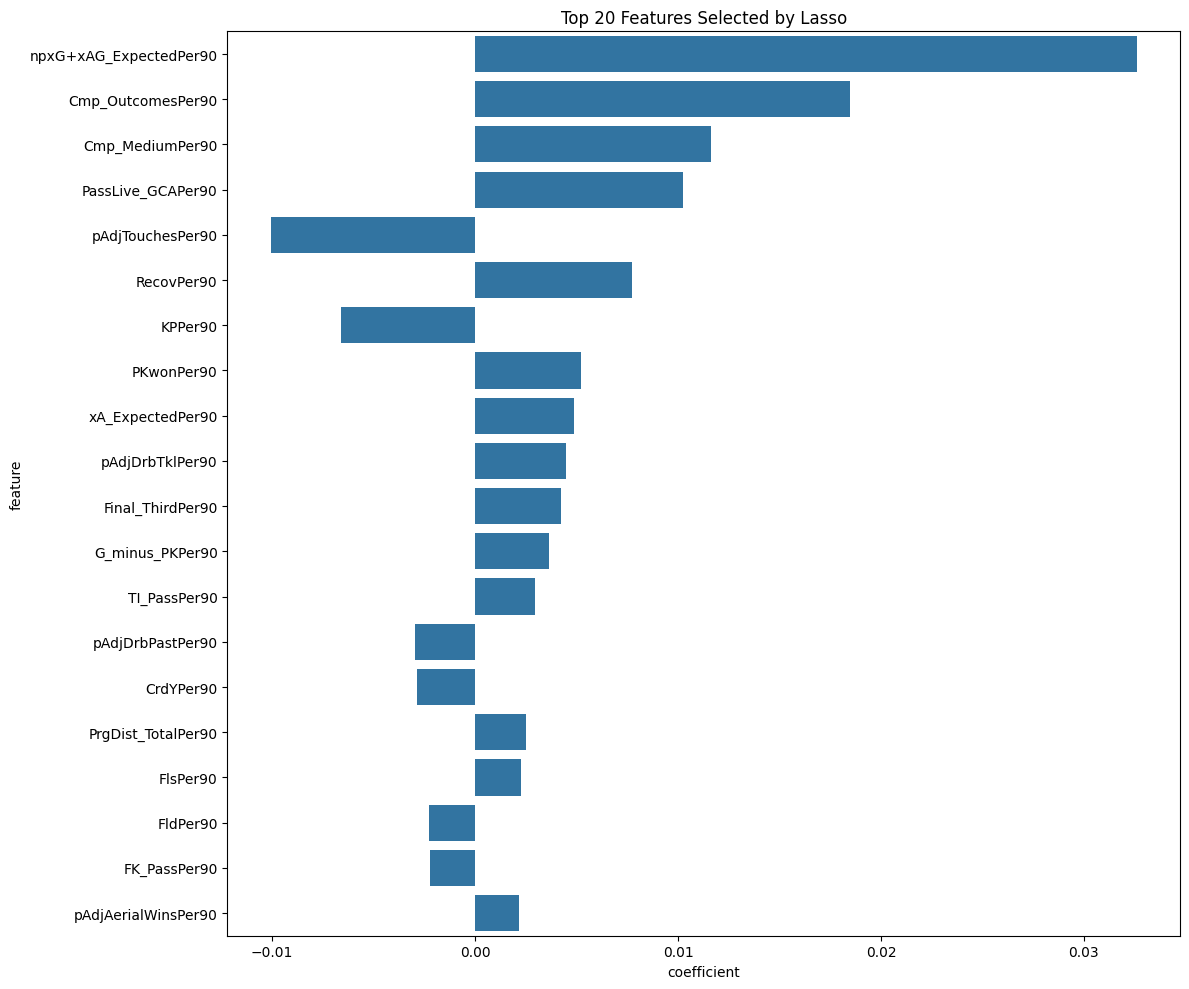

In [8]:
# Setup cross-validation with multiple alphas
lasso_cv = LassoCV(
    cv=5,
    random_state=42,
    max_iter=10000,
    alphas=np.logspace(-6, 6, 100)
)

# Fit on scaled training data
lasso_cv.fit(X_train_scaled, y_train)

print(f"Best Lasso alpha: {lasso_cv.alpha_:.4f}")

# Get non-zero coefficients
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'coefficient': lasso_cv.coef_
})

# Sort by absolute coefficient value
feature_importance['abs_coef'] = feature_importance['coefficient'].abs()
selected_features = feature_importance[feature_importance.coefficient != 0].sort_values('abs_coef', ascending=False)

print(f"\nLasso selected {len(selected_features)} features:")
print(selected_features.to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='coefficient', y='feature', 
           data=selected_features.head(20))
plt.title('Top 20 Features Selected by Lasso')
plt.tight_layout()
plt.savefig('lasso_feature_importance.png')
plt.show()

# Save selected feature names for next step
selected_feature_names = selected_features['feature'].tolist()

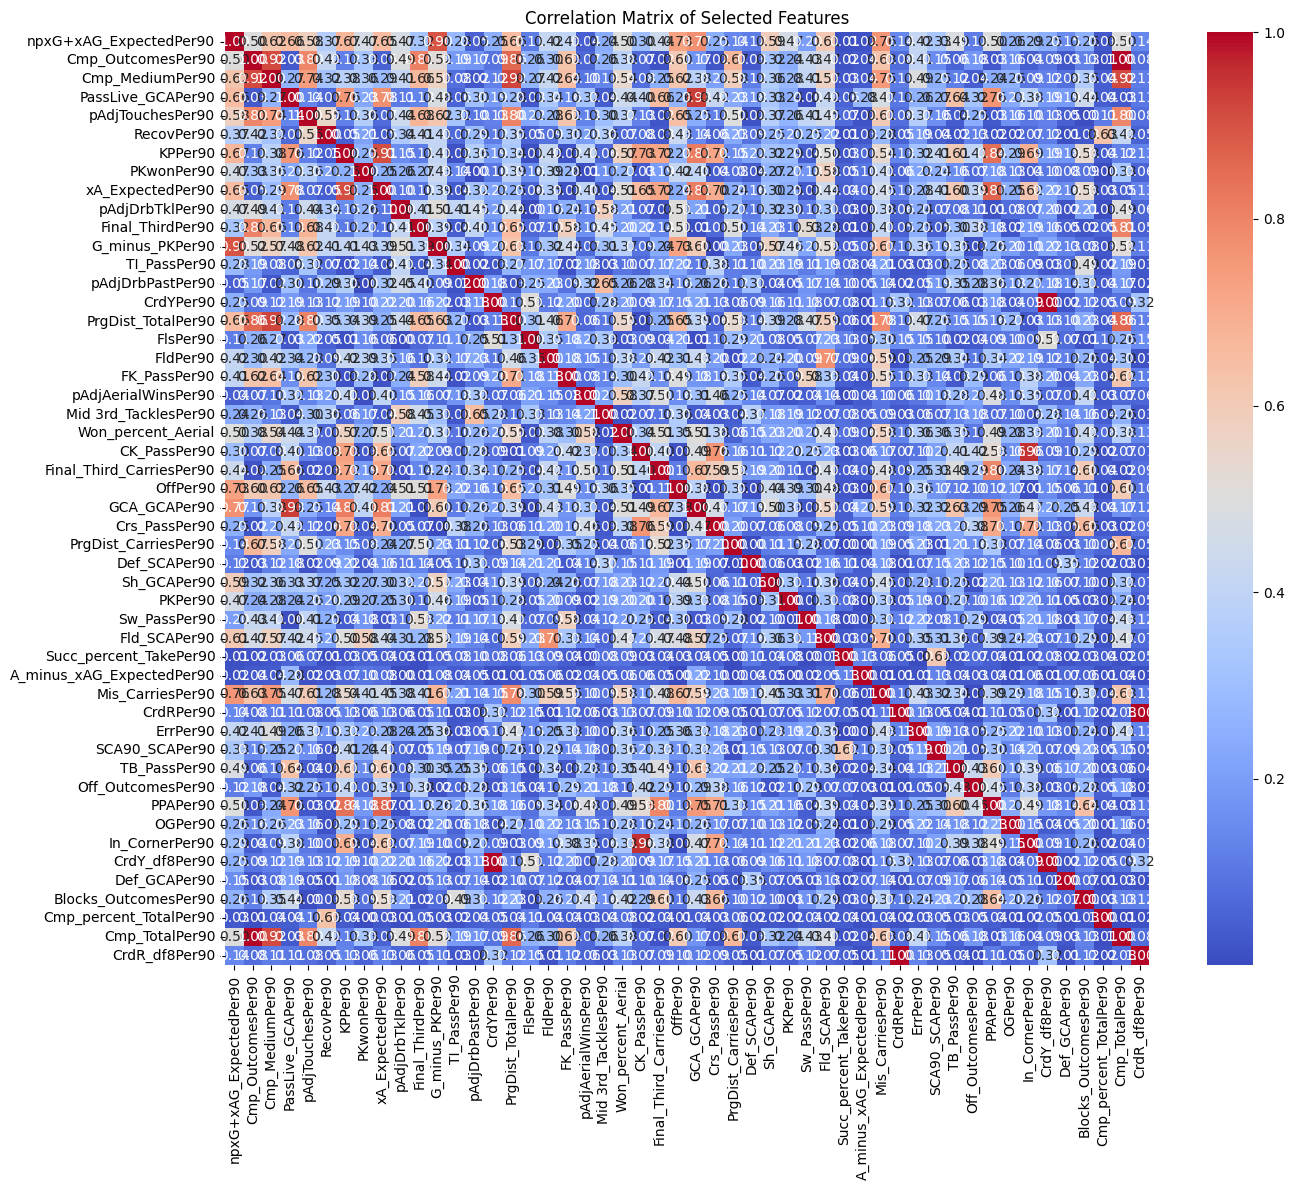


Highly correlated feature pairs:
npxG+xAG_ExpectedPer90 and G_minus_PKPer90: 0.895
Cmp_OutcomesPer90 and Cmp_MediumPer90: 0.916
Cmp_OutcomesPer90 and Final_ThirdPer90: 0.806
Cmp_OutcomesPer90 and PrgDist_TotalPer90: 0.861
Cmp_OutcomesPer90 and Cmp_TotalPer90: 1.000
Cmp_MediumPer90 and PrgDist_TotalPer90: 0.924
Cmp_MediumPer90 and Cmp_TotalPer90: 0.916
PassLive_GCAPer90 and GCA_GCAPer90: 0.935
pAdjTouchesPer90 and PrgDist_TotalPer90: 0.801
KPPer90 and xA_ExpectedPer90: 0.908
KPPer90 and GCA_GCAPer90: 0.814
KPPer90 and PPAPer90: 0.841
xA_ExpectedPer90 and GCA_GCAPer90: 0.814
xA_ExpectedPer90 and PPAPer90: 0.870
Final_ThirdPer90 and Cmp_TotalPer90: 0.806
CrdYPer90 and CrdY_df8Per90: 1.000
PrgDist_TotalPer90 and Cmp_TotalPer90: 0.861
CK_PassPer90 and In_CornerPer90: 0.956
CrdRPer90 and CrdR_df8Per90: 1.000

Features to consider removing due to multicollinearity: ['G_minus_PKPer90', 'Cmp_MediumPer90', 'Final_ThirdPer90', 'PrgDist_TotalPer90', 'Cmp_TotalPer90', 'GCA_GCAPer90', 'pAdjTouchesP

In [9]:
# Get correlation matrix for selected features only
X_selected = X[selected_feature_names]
corr_matrix = X_selected.corr().abs()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.savefig('feature_correlation_matrix.png')
plt.show()

# Identify highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:  # Threshold for high correlation
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.3f}")
    
    # For each highly correlated pair, keep the one with higher correlation to target
    features_to_remove = []
    for feat1, feat2, _ in high_corr_pairs:
        corr1 = abs(np.corrcoef(X[feat1], y)[0, 1])
        corr2 = abs(np.corrcoef(X[feat2], y)[0, 1])
        if corr1 < corr2:
            if feat1 not in features_to_remove:
                features_to_remove.append(feat1)
        else:
            if feat2 not in features_to_remove:
                features_to_remove.append(feat2)
    
    print(f"\nFeatures to consider removing due to multicollinearity: {features_to_remove}")
    
    # Create refined feature list
    refined_features = [f for f in selected_feature_names if f not in features_to_remove]
    print(f"\nRefined feature list ({len(refined_features)} features):")
    print(refined_features)
else:
    refined_features = selected_feature_names
    print("\nNo high multicollinearity detected among selected features")